In [385]:
import cv2
import os
import pandas as pd
import numpy as np
import keras, tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import save_model
from keras.models import load_model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split


In [188]:
def extract(img, smaller):
        
    # Convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

    if(smaller):
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))

        # Applying dilation on the threshold image
        dilation = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, rect_kernel, iterations = 1)
        # dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
    else:
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

        # Applying dilation on the threshold image
        dilation = cv2.dilate(thresh1, rect_kernel, iterations = 2)

    # Finding contours
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, 
                                                    cv2.CHAIN_APPROX_NONE)

    return contours

In [192]:
def boundingbox(img_path, model):
    img = cv2.imread(img_path)
    contours = extract(img, False)

    sum = 0
    y_pred = []
    boxes = []
    im = img.copy()
    crops = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Cropping the text block
        cropped = img[y:y + h, x:x + w]

        # extract each alphabet from each block
        contours2 = extract(cropped, True)
        
        for i in contours2:
            # count alphabets 
            sum += 1

            x2, y2, w2, h2 = cv2.boundingRect(i)
            
            cropped2 = img[y+y2: y+y2+h2, x+x2: x+x2+w2]
            
            # center_x = (x + x2 + w2 / 2) / img.shape[1]
            # center_y = (y + y2 + h2 / 2) / img.shape[0]
            # normalized_width = w2 / img.shape[1]
            # normalized_height = h2 / img.shape[0]

            # # Append the YOLO format coordinates to the boxes list
            # boxes.append([center_x, center_y, normalized_width, normalized_height])


            boxes.append([x+x2, y+y2, x+x2 + w2, y+y2 + h2]) 

            cropped2 = cv2.resize(cropped2, (64,64))
            
            crops.append(cropped2)

            cropped2 = cropped2.reshape((1, 64, 64, 3))

            y_pred.append(model.predict(cropped2))

    
    order = np.argsort([x[0] for x in boxes])
    boxes = [boxes[x] for x in order]
    crops = [crops[x] for x in order]
    y_pred = [y_pred[x] for x in order]
    
    y_pred = np.array(y_pred)
    return sum, y_pred, boxes, im, crops


In [363]:
# each classes(37 classes) has 55 images except # that have 20 
model_training_csv = os.path.join(os.getcwd(), 'alphabets/english.csv')
model_image_training = os.path.join(os.getcwd(), 'alphabets')

# make dataframe for training model 
model_training_df = pd.read_csv(model_training_csv)
# add columns of image
model_training_df['img'] = ''
# get image for each image name
for i in range(len(model_training_df)):
    img_path = os.path.join(model_image_training, model_training_df.at[i, 'image'])
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))

    model_training_df.at[i, 'img'] = img
# get all class names
class_names = model_training_df.label.unique()

# Convert each column to NumPy arrays
labels = model_training_df['label'].to_numpy()
images = np.array(model_training_df['img'].tolist())
image_names = model_training_df['image'].to_numpy()
new_image_names = np.array([(item.split('/')[1]).split('.')[0] for item in model_training_df['image']])

# split each class equaly
x_train, y_train, x_test, y_test = [], [], [], []
temp = []
for name in class_names:
    split = model_training_df[model_training_df.label == name]
    X = split['img']
    Y = split['label']
    Y = [np.where(class_names == label)[0] for label in Y]

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.8)

    x_train.extend(X_train)
    y_train.extend(Y_train)
    x_test.extend(X_test)
    y_test.extend(Y_test)


# shuffle order of train and test data
temp_x_train, temp_y_train, temp_x_test, temp_y_test = [], [], [], []

train_rand_order = np.arange(len(x_train))
test_rand_order = np.arange(len(x_test))
np.random.shuffle(train_rand_order)
np.random.shuffle(test_rand_order)
for i in train_rand_order:
    temp_x_train.append(x_train[i])
    temp_y_train.append(y_train[i])

for j in test_rand_order:
    temp_x_test.append(x_test[j])
    temp_y_test.append(y_test[j])    

x_train = np.array(temp_x_train, dtype=np.float32)
x_test = np.array(temp_x_test, dtype=np.float32)
y_train = np.array(temp_y_train)
y_test = np.array(temp_y_test)


# one-hot-encoded the label
y_train = keras.utils.to_categorical(y_train, len(class_names))
y_test = keras.utils.to_categorical(y_test, len(class_names))

In [364]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.4, 0.4],
    rotation_range=0.3,
)

datagen.fit(x_train)


In [373]:
model = Sequential()
# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(37, activation='softmax'))
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_202 (Conv2D)         (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_141 (MaxPool  (None, 32, 32, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_203 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_142 (MaxPool  (None, 16, 16, 128)       0         
 ing2D)                                                          
                                                                 
 conv2d_204 (Conv2D)         (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_143 (MaxPool  (None, 8, 8, 128)       

In [374]:
batch_size = 32

# initiate Adam optimizer
# Using M1 mac
opt = keras.optimizers.legacy.Adam(learning_rate=0.0005)

model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

history_1 = model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=25,
                        validation_data=(x_test, y_test),
                        shuffle=True)


Epoch 1/25
85/85 [==============================] - 13s 148ms/step - loss: 9.4416 - accuracy: 0.0420 - val_loss: 3.5599 - val_accuracy: 0.0539
Epoch 2/25
85/85 [==============================] - 14s 166ms/step - loss: 3.2528 - accuracy: 0.1224 - val_loss: 3.8221 - val_accuracy: 0.0364
Epoch 3/25
85/85 [==============================] - 17s 202ms/step - loss: 2.6949 - accuracy: 0.2423 - val_loss: 3.4132 - val_accuracy: 0.0889
Epoch 4/25
85/85 [==============================] - 16s 183ms/step - loss: 2.2287 - accuracy: 0.3643 - val_loss: 3.6069 - val_accuracy: 0.0802
Epoch 5/25
85/85 [==============================] - 18s 214ms/step - loss: 1.8932 - accuracy: 0.4451 - val_loss: 3.2951 - val_accuracy: 0.1399
Epoch 6/25
85/85 [==============================] - 15s 180ms/step - loss: 1.7163 - accuracy: 0.4889 - val_loss: 3.5351 - val_accuracy: 0.1006
Epoch 7/25
85/85 [==============================] - 15s 172ms/step - loss: 1.6300 - accuracy: 0.5247 - val_loss: 4.1174 - val_accuracy: 0.0729

In [380]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(x_train, y_train, verbose=0)))
print(' Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(x_test, y_test, verbose=0)))
print()

y_pred = model.predict(x_test, verbose=0)

y_test_1d = np.argmax(y_test, axis=1)
y_pred_1d = np.argmax(y_pred, axis=1)
    
cm = confusion_matrix(y_true=y_test_1d, y_pred=y_pred_1d).T
print(cm)

Train Loss: 2.904616, Accuracy: 0.237245
 Test Loss: 2.885580, Accuracy: 0.252187

[[ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  1  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  1 ...  1 10  0]
 [ 0  0  0 ...  1  0  4]]


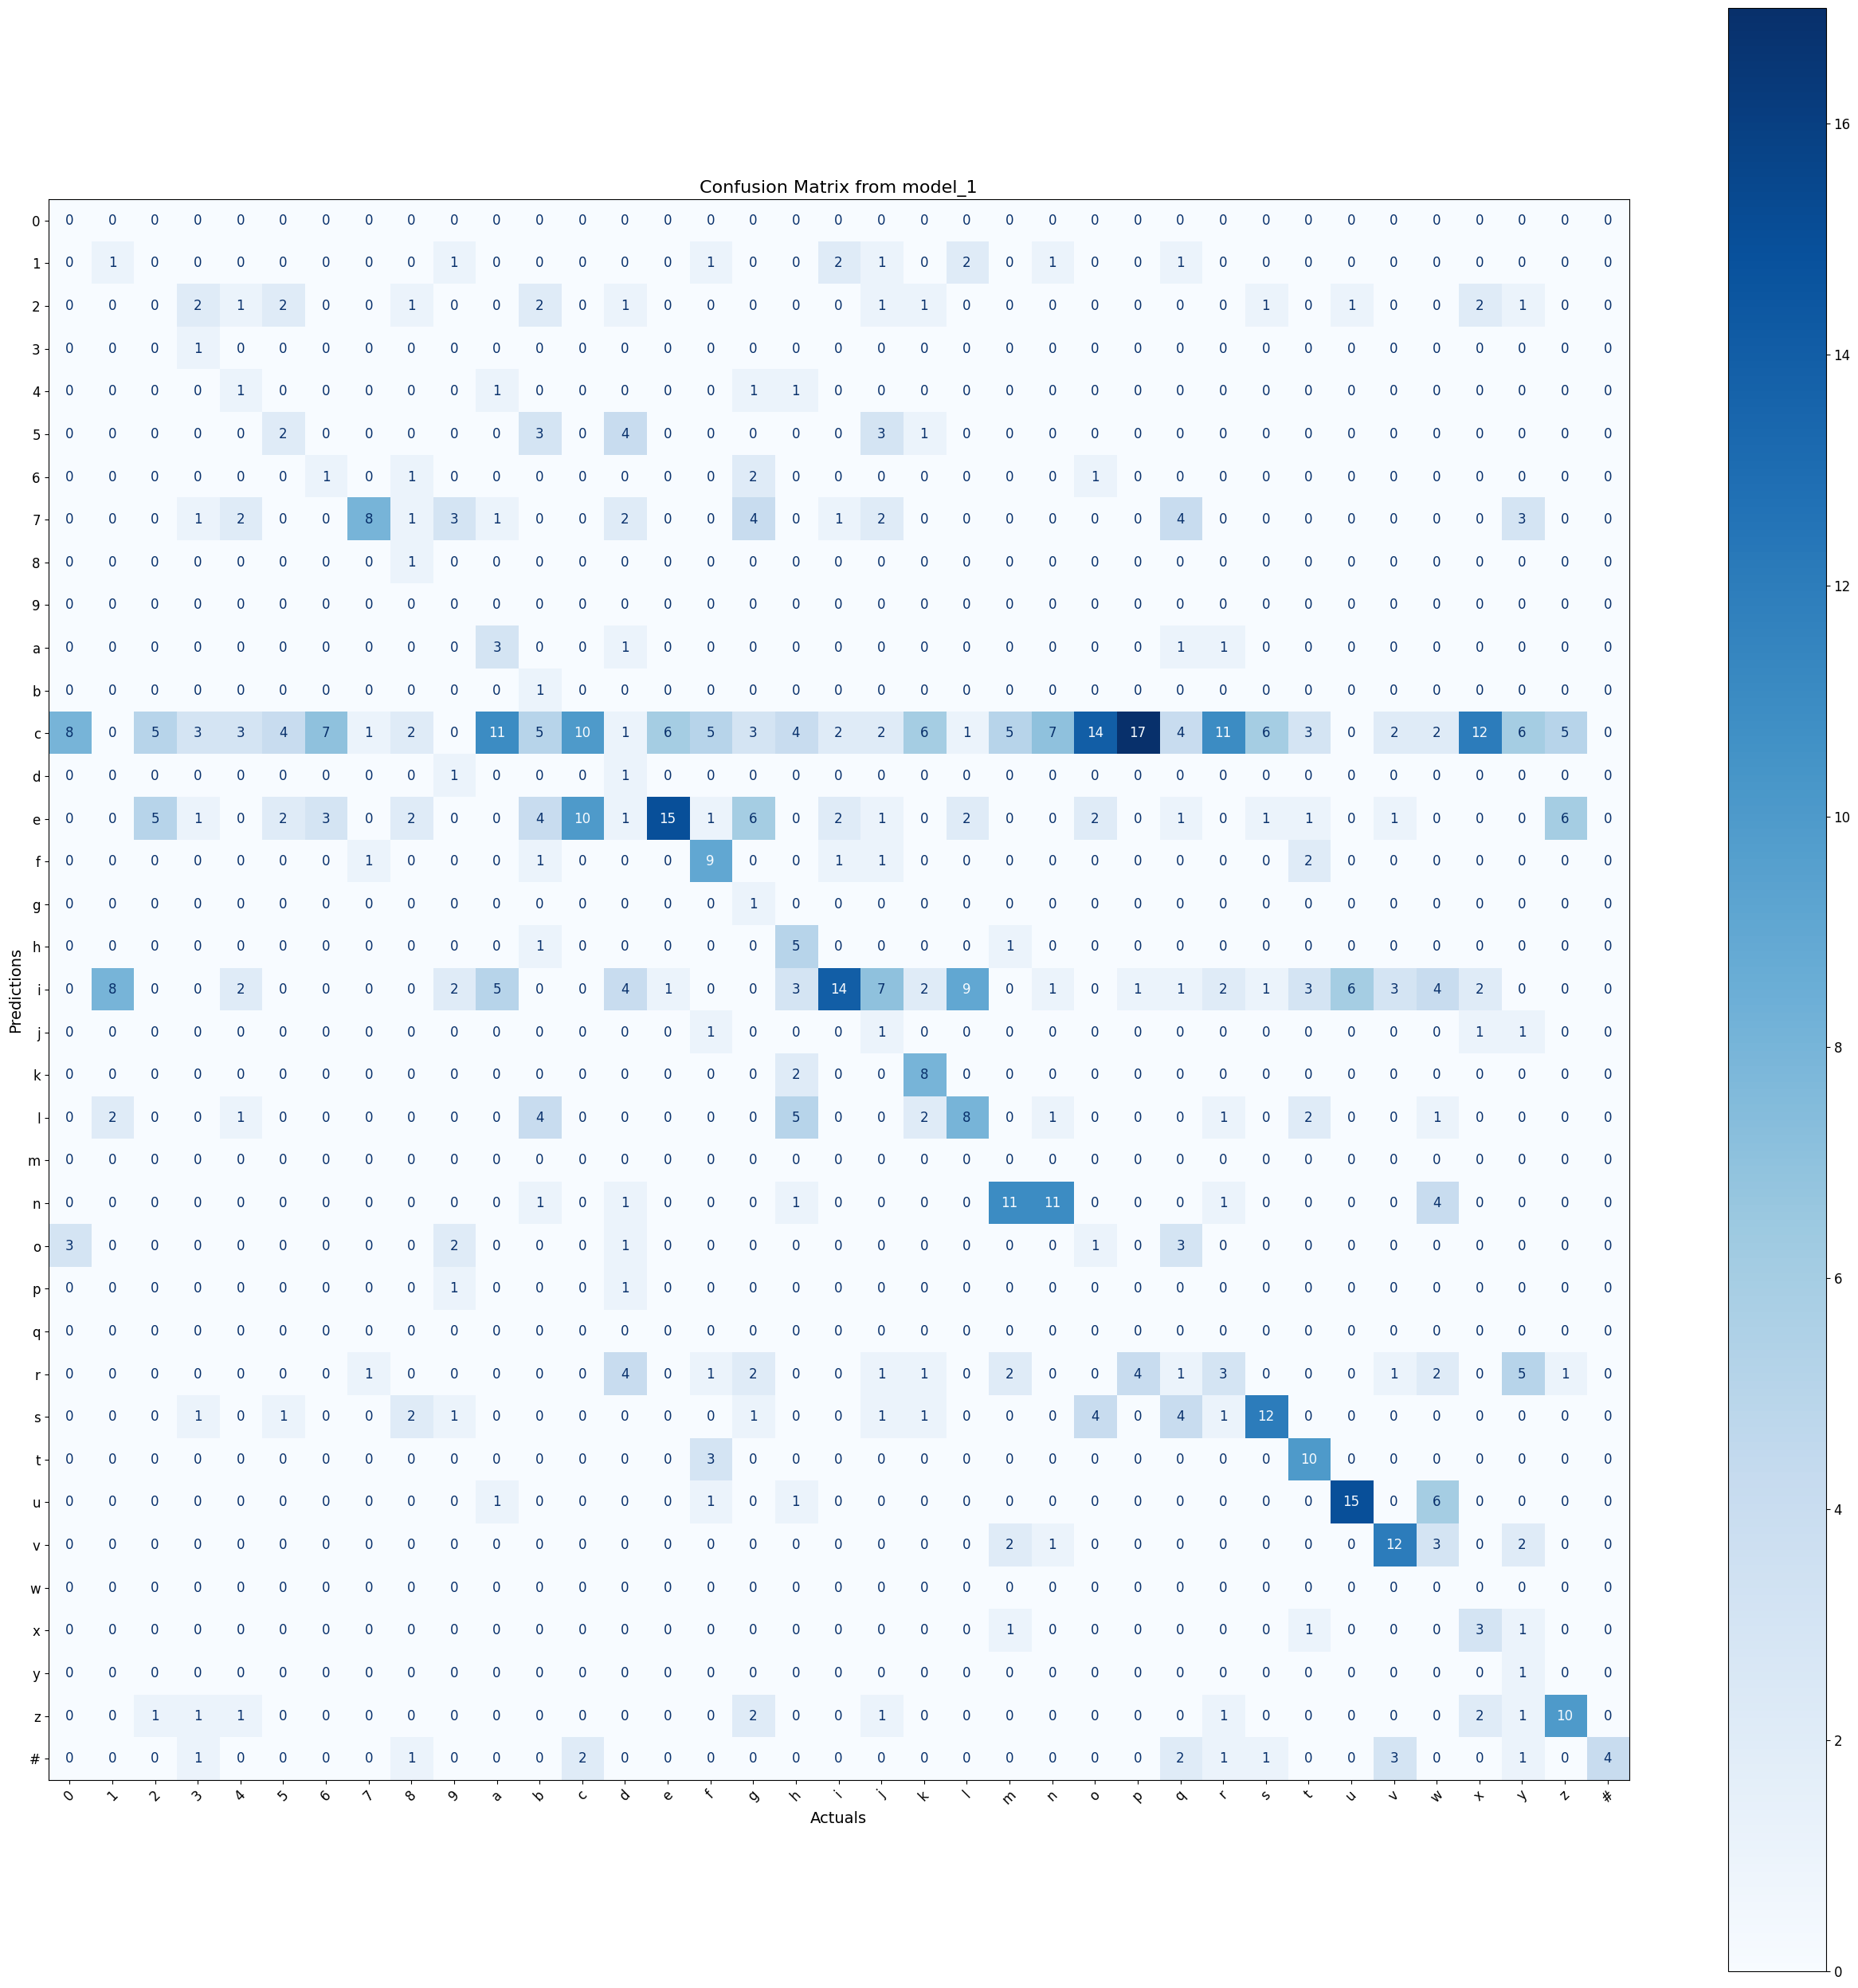

In [381]:
plt.rcParams.update({'font.size': 12})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(32, 32))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xlabel('Actuals', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)    
plt.title('Confusion Matrix from model_1', fontsize=16)
plt.show()

In [382]:
np.set_printoptions(precision=2)
# classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names)
print(classification_report(y_true=y_test_1d, y_pred=y_pred_1d, target_names=class_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.10      0.09      0.10        11
           2       0.00      0.00      0.00        11
           3       1.00      0.09      0.17        11
           4       0.25      0.09      0.13        11
           5       0.15      0.18      0.17        11
           6       0.20      0.09      0.13        11
           7       0.25      0.73      0.37        11
           8       1.00      0.09      0.17        11
           9       0.00      0.00      0.00        11
           a       0.50      0.14      0.21        22
           b       1.00      0.05      0.09        22
           c       0.05      0.45      0.10        22
           d       0.50      0.05      0.08        22
           e       0.22      0.68      0.34        22
           f       0.60      0.41      0.49        22
           g       1.00      0.05      0.09        22
           h       0.71    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [ ]:
# ans = 'StandardRNNshavepoormemory'
# num_of_char, y_pred, boxes, img, crop = boundingbox(os.path.join(os.getcwd(), "com_text3.png"), model)

# ans = 'hw2routingalgorithm'
# num_of_char, y_pred, boxes, img, crop = boundingbox(os.path.join(os.getcwd(), "com_text5.png"), model)

# ans = 'alotofbags'
# num_of_char, y_pred, boxes, img, crop = boundingbox(os.path.join(os.getcwd(), "com_text6.png"), model)

# ans = '2dishes35sweet'
# num_of_char, y_pred, boxes, img, crop = boundingbox(os.path.join(os.getcwd(), "com_text7.png"), model)

ans = 'hashtag#'
num_of_char, y_pred, boxes, img, crop = boundingbox(os.path.join(os.getcwd(), "com_text8.png"), model)

word = ''
for i in y_pred:
    m = np.argmax(i)
    word += class_names[m]
print(word)
print(ans.lower())

1/1 [==============================] - 0s 13ms/step
hazhhag8
hashtag#


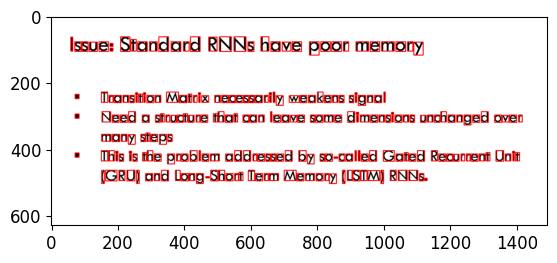

In [ ]:
# save resulting image
for x1, y1, x2, y2 in boxes:
    rect = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
plt.imshow(img)
# plt.imshow(crop[1])

In [ ]:
model.save('SSFF_model.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [386]:
ssff = load_model('SSFF_model.h5')

In [391]:
ans = ''
num_of_char, y_pred, boxes, img, crop = boundingbox(os.path.join(os.getcwd(), ""), ssff)

word = ''
for i in y_pred:
    m = np.argmax(i)
    word += class_names[m]
print(word)
print(ans.lower())

1/1 [==============================] - 0s 14ms/step
stcdecternn5hovepootmemoty
standardrnnshavepoormemory
